In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('ola.csv')

In [8]:
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,3,2,7.653428,122.430885,18.783703,5,128,315.731778
1,2011-01-01 01:00:00,4,3,13.269244,101.703802,14.035245,36,184,340.457093
2,2011-01-01 02:00:00,1,3,30.886922,77.583743,45.365080,34,97,224.278595
3,2011-01-01 03:00:00,3,1,10.463377,114.925671,25.347168,6,47,132.169549
4,2011-01-01 04:00:00,3,4,30.214783,149.193592,20.288982,14,199,315.867137


In [9]:
df.shape

(10886, 9)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   weather     10886 non-null  int64  
 3   temp        9254 non-null   float64
 4   humidity    9254 non-null   float64
 5   windspeed   9254 non-null   float64
 6   casual      10886 non-null  int64  
 7   registered  10886 non-null  int64  
 8   count       10886 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 765.6+ KB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.493937,1.120531,1.000000,1.000000,2.000000,3.000000,4.000000
weather,10886.0,2.491916,1.123139,1.000000,1.000000,2.000000,4.000000,4.000000
temp,9254.0,23.240116,20.311144,-22.743852,12.470555,20.743790,29.394576,211.102548
humidity,9254.0,124.452421,75.568291,32.713561,87.846187,112.180064,137.301002,672.687236
windspeed,9254.0,34.549616,28.417263,-1.407737,17.963252,30.945593,44.029018,244.921965
casual,10886.0,24.517545,14.390014,0.000000,12.000000,25.000000,37.000000,49.000000
registered,10886.0,99.551442,57.541131,0.000000,50.000000,100.000000,149.000000,199.000000
count,10886.0,224.177267,75.228602,-12.769738,170.140221,224.257587,278.407366,464.839068


In [12]:
parts = df["datetime"].str.split(" ", n=2, expand = True)
df["date"] = parts[0]
df["time"] = parts[1].str[:2].astype('int')
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time
0,2011-01-01 00:00:00,3,2,7.653428,122.430885,18.783703,5,128,315.731778,2011-01-01,0
1,2011-01-01 01:00:00,4,3,13.269244,101.703802,14.035245,36,184,340.457093,2011-01-01,1
2,2011-01-01 02:00:00,1,3,30.886922,77.583743,45.365080,34,97,224.278595,2011-01-01,2
3,2011-01-01 03:00:00,3,1,10.463377,114.925671,25.347168,6,47,132.169549,2011-01-01,3
4,2011-01-01 04:00:00,3,4,30.214783,149.193592,20.288982,14,199,315.867137,2011-01-01,4


In [13]:
parts = df["date"].str.split("-", n=3, expand=True)
df["day"] = parts[0].astype('int')
df["month"] = parts[1].astype('int')
df["year"] = parts[2].astype('int')
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time,day,month,year
0,2011-01-01 00:00:00,3,2,7.653428,122.430885,18.783703,5,128,315.731778,2011-01-01,0,2011,1,1
1,2011-01-01 01:00:00,4,3,13.269244,101.703802,14.035245,36,184,340.457093,2011-01-01,1,2011,1,1
2,2011-01-01 02:00:00,1,3,30.886922,77.583743,45.365080,34,97,224.278595,2011-01-01,2,2011,1,1
3,2011-01-01 03:00:00,3,1,10.463377,114.925671,25.347168,6,47,132.169549,2011-01-01,3,2011,1,1
4,2011-01-01 04:00:00,3,4,30.214783,149.193592,20.288982,14,199,315.867137,2011-01-01,4,2011,1,1


Whether it is a weekend or a weekday must have some effect on the ride request count.

In [14]:
from datetime import datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

def weekend_or_weekday(year,month,day):
    try:
        d = datetime(year,month, day)
        return 0 if d.weekday() > 4 else 1
    except ValueError:
        return np.nan

df['weekday'] = df.apply(lambda x: weekend_or_weekday(x['year'], x['month'] , x['day']), axis = 1)

df.head()


,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday
0,2011-01-01 00:00:00,3,2,7.653428,122.430885,18.783703,5,128,315.731778,2011-01-01,0,1,1,2011,0
1,2011-01-01 01:00:00,4,3,13.269244,101.703802,14.035245,36,184,340.457093,2011-01-01,1,1,1,2011,0
2,2011-01-01 02:00:00,1,3,30.886922,77.583743,45.365080,34,97,224.278595,2011-01-01,2,1,1,2011,0
3,2011-01-01 03:00:00,3,1,10.463377,114.925671,25.347168,6,47,132.169549,2011-01-01,3,1,1,2011,0
4,2011-01-01 04:00:00,3,4,30.214783,149.193592,20.288982,14,199,315.867137,2011-01-01,4,1,1,2011,0


In [15]:
def am_or_pm(x):
    if x > 11:
        return 1
    else:
        return 0

In [16]:
df['am_or_pm'] = df['time'].apply(am_or_pm)
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday,am_or_pm
0,2011-01-01 00:00:00,3,2,7.653428,122.430885,18.783703,5,128,315.731778,2011-01-01,0,1,1,2011,0,0
1,2011-01-01 01:00:00,4,3,13.269244,101.703802,14.035245,36,184,340.457093,2011-01-01,1,1,1,2011,0,0
2,2011-01-01 02:00:00,1,3,30.886922,77.583743,45.365080,34,97,224.278595,2011-01-01,2,1,1,2011,0,0
3,2011-01-01 03:00:00,3,1,10.463377,114.925671,25.347168,6,47,132.169549,2011-01-01,3,1,1,2011,0,0
4,2011-01-01 04:00:00,3,4,30.214783,149.193592,20.288982,14,199,315.867137,2011-01-01,4,1,1,2011,0,0


In [17]:
from datetime import date

import holidays

def is_holiday(x):
    indian_holidays = holidays.country_holidays('IN')
    if indian_holidays.get(x):
        return 1
    else :
        return 0

df['holidays'] = df['date'].apply(is_holiday)
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday,am_or_pm,holidays
0,2011-01-01 00:00:00,3,2,7.653428,122.430885,18.783703,5,128,315.731778,2011-01-01,0,1,1,2011,0,0,0
1,2011-01-01 01:00:00,4,3,13.269244,101.703802,14.035245,36,184,340.457093,2011-01-01,1,1,1,2011,0,0,0
2,2011-01-01 02:00:00,1,3,30.886922,77.583743,45.365080,34,97,224.278595,2011-01-01,2,1,1,2011,0,0,0
3,2011-01-01 03:00:00,3,1,10.463377,114.925671,25.347168,6,47,132.169549,2011-01-01,3,1,1,2011,0,0,0
4,2011-01-01 04:00:00,3,4,30.214783,149.193592,20.288982,14,199,315.867137,2011-01-01,4,1,1,2011,0,0,0


In [18]:
df.drop(['datetime', 'date'], axis = 1, inplace = True)

In [19]:
df.isnull().sum()

,0
season,0
weather,0
temp,1632
humidity,1632
windspeed,1632
casual,0
registered,0
count,0
time,0
day,0


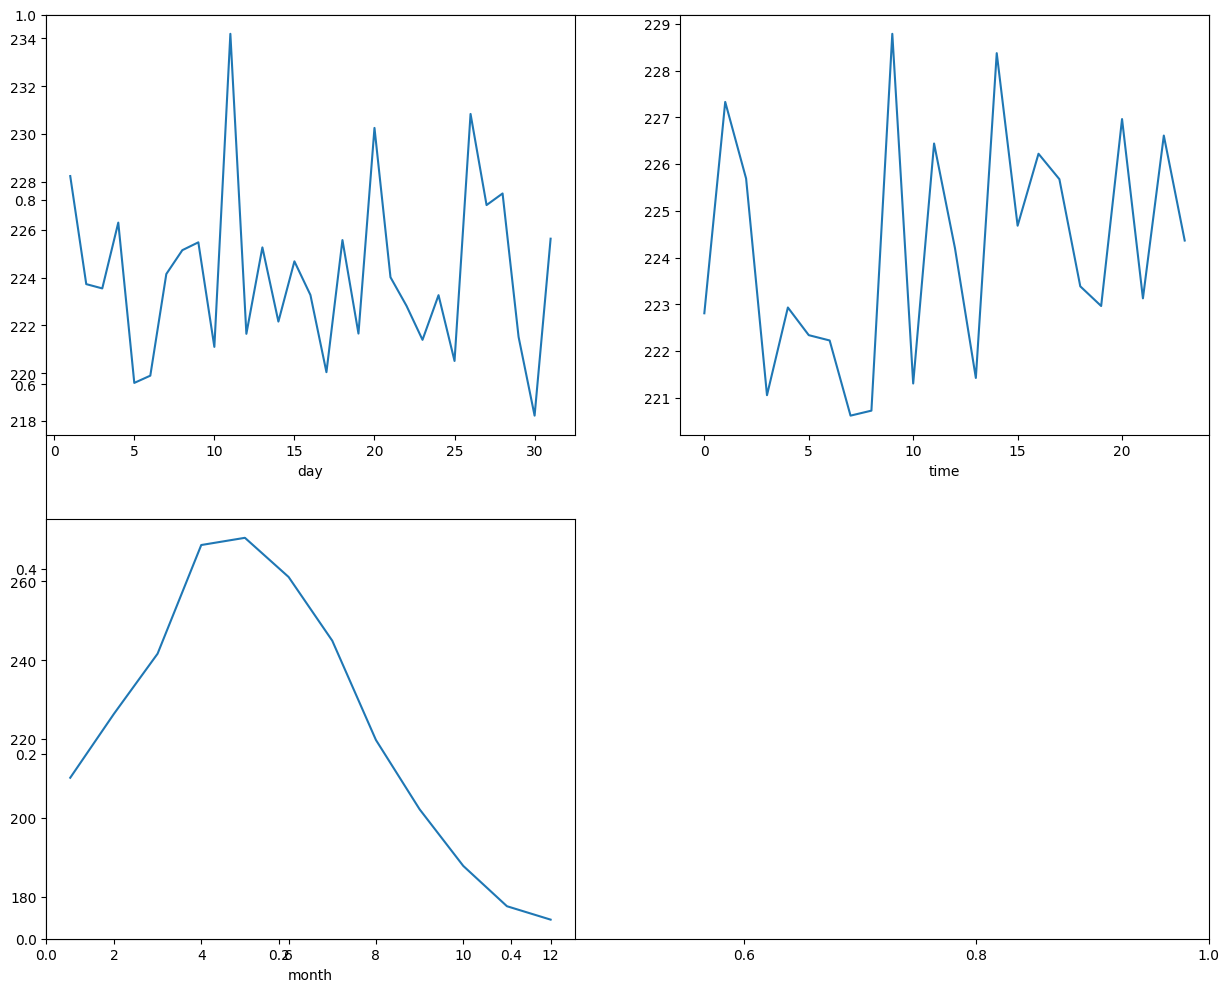

In [20]:
# check for any relation between the ride request count with respect to the day, time, or month.

features = ['day', 'time', 'month']
plt.subplots(figsize= (15,12))

for i,col in enumerate(features):
    plt.subplot(2,2,i+1)
    df.groupby(col).mean()['count'].plot()

plt.show()

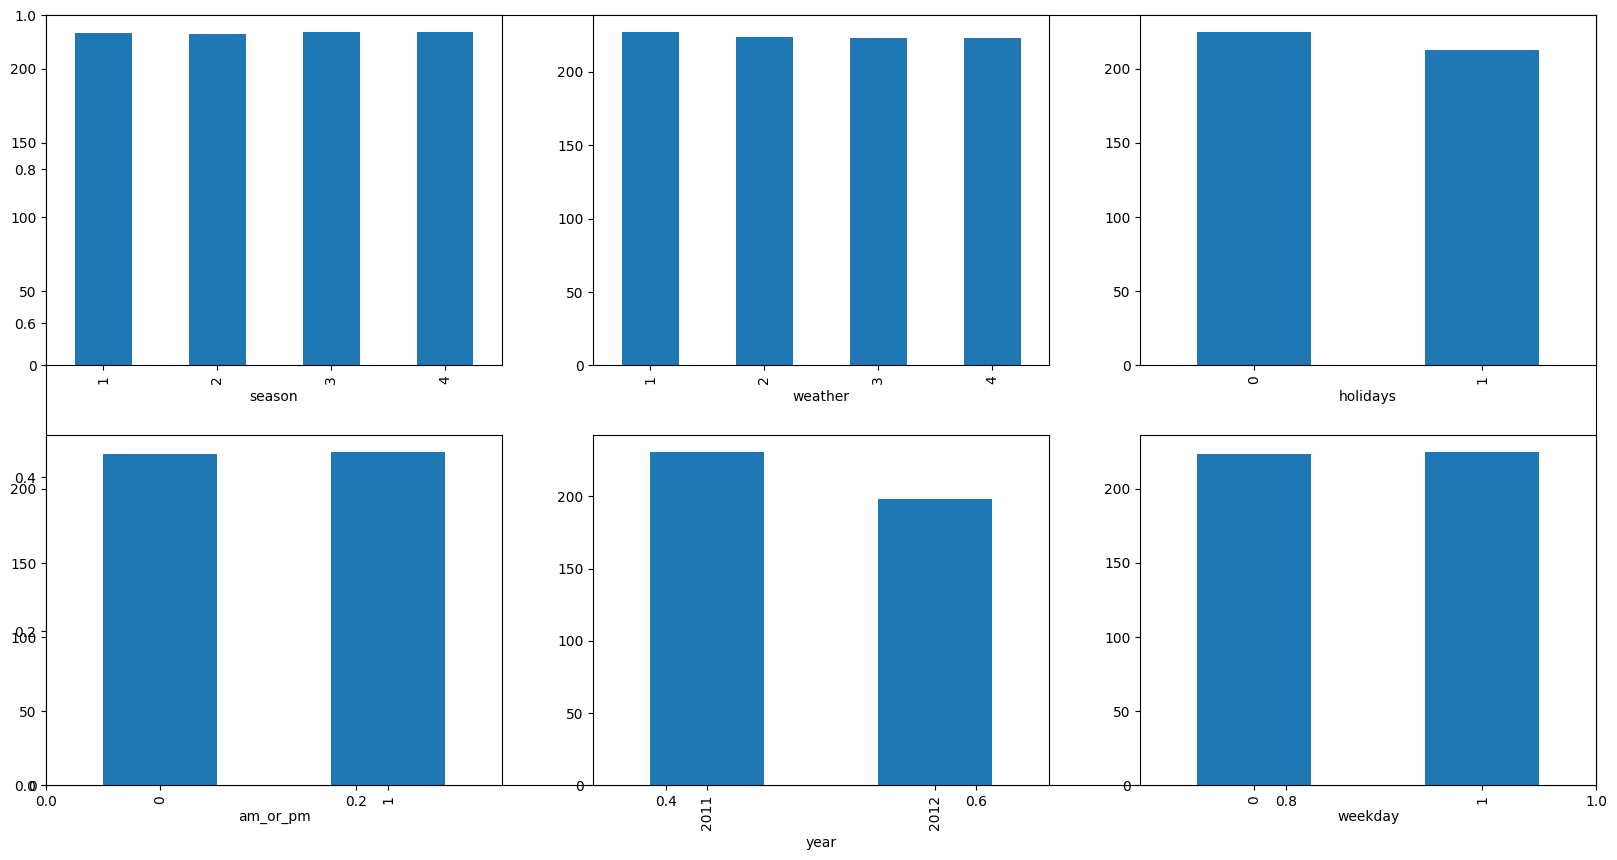

In [21]:
features = ['season', 'weather', 'holidays',\
            'am_or_pm', 'year', 'weekday']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    df.groupby(col).mean()['count'].plot.bar()

plt.show()

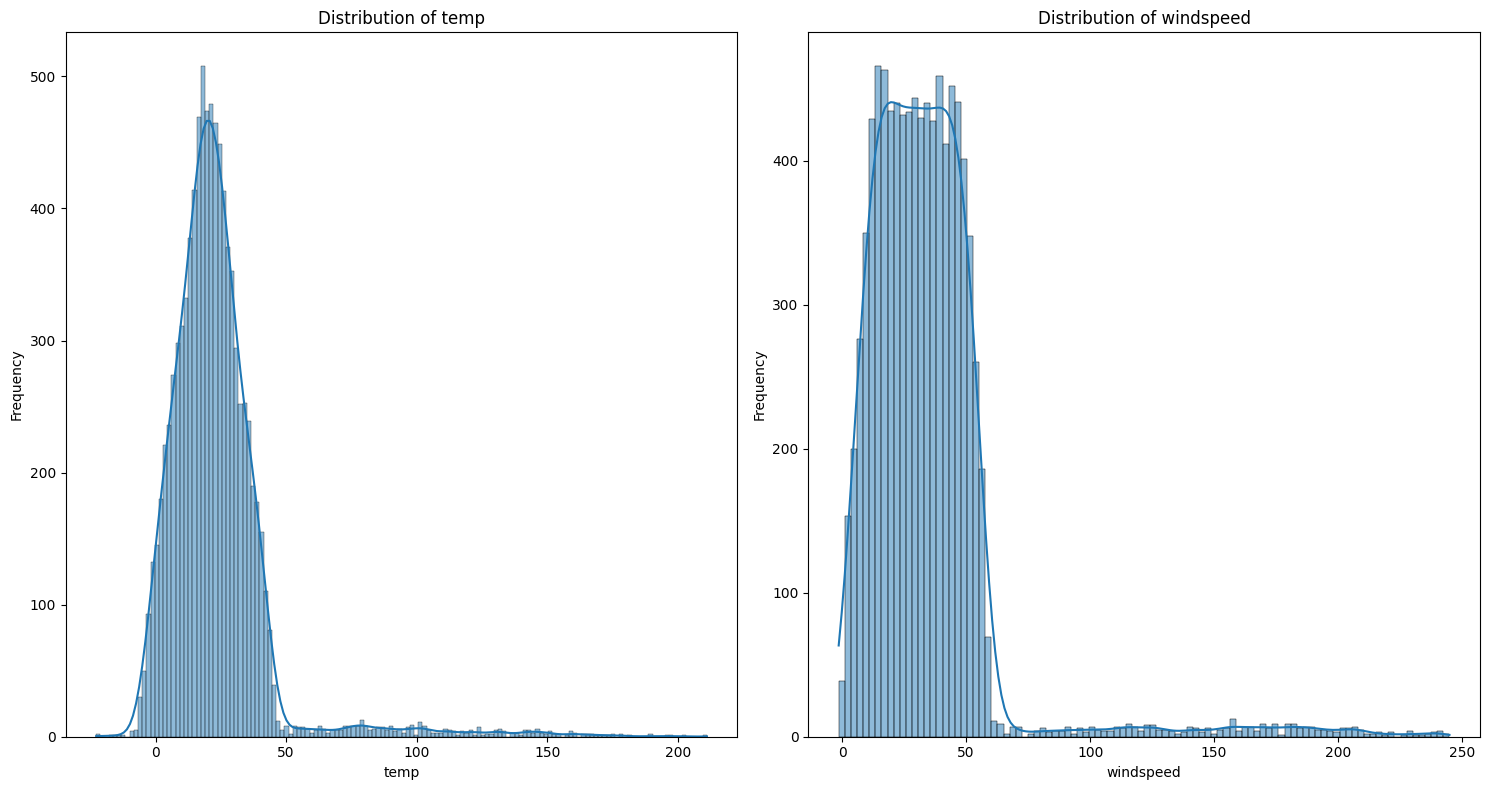

In [22]:
features = ['temp', 'windspeed']

plt.figure(figsize=(15, 8))

for i, col in enumerate(features):
    plt.subplot(1, 2, i+1)
    sb.histplot(df[col], kde=True)  # Histogram with KDE curve
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

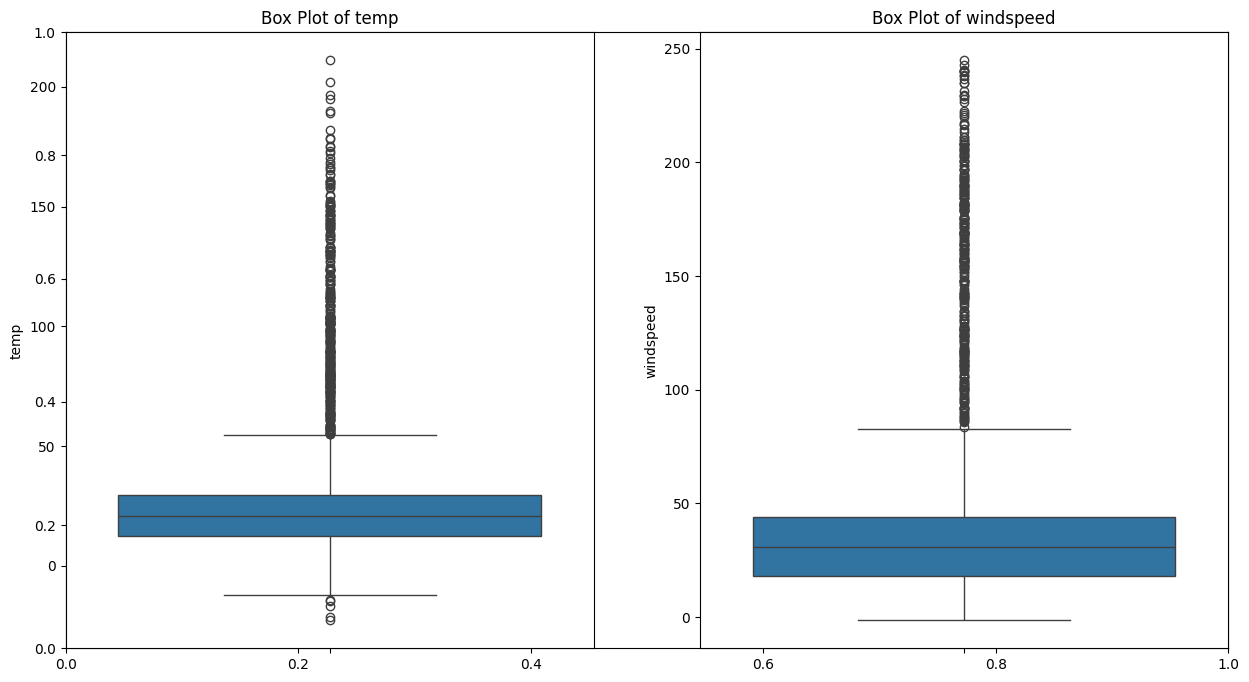

In [23]:
features = ['temp', 'windspeed']

plt.subplots(figsize= (15,8))

for i, col in enumerate(features):
    plt.subplot(1, 2, i+1)
    sb.boxplot(df[col])
    plt.title(f'Box Plot of {col}')

plt.show()

We have outliers, let's check how much data we will lose if we remove outliers.

In [24]:
num_rows = df.shape[0] - df[df['windspeed'] < 32].shape[0]
print(f'No of rows that will be lost if we remove outliers : {num_rows}.')

No of rows that will be lost if we remove outliers : 6091.


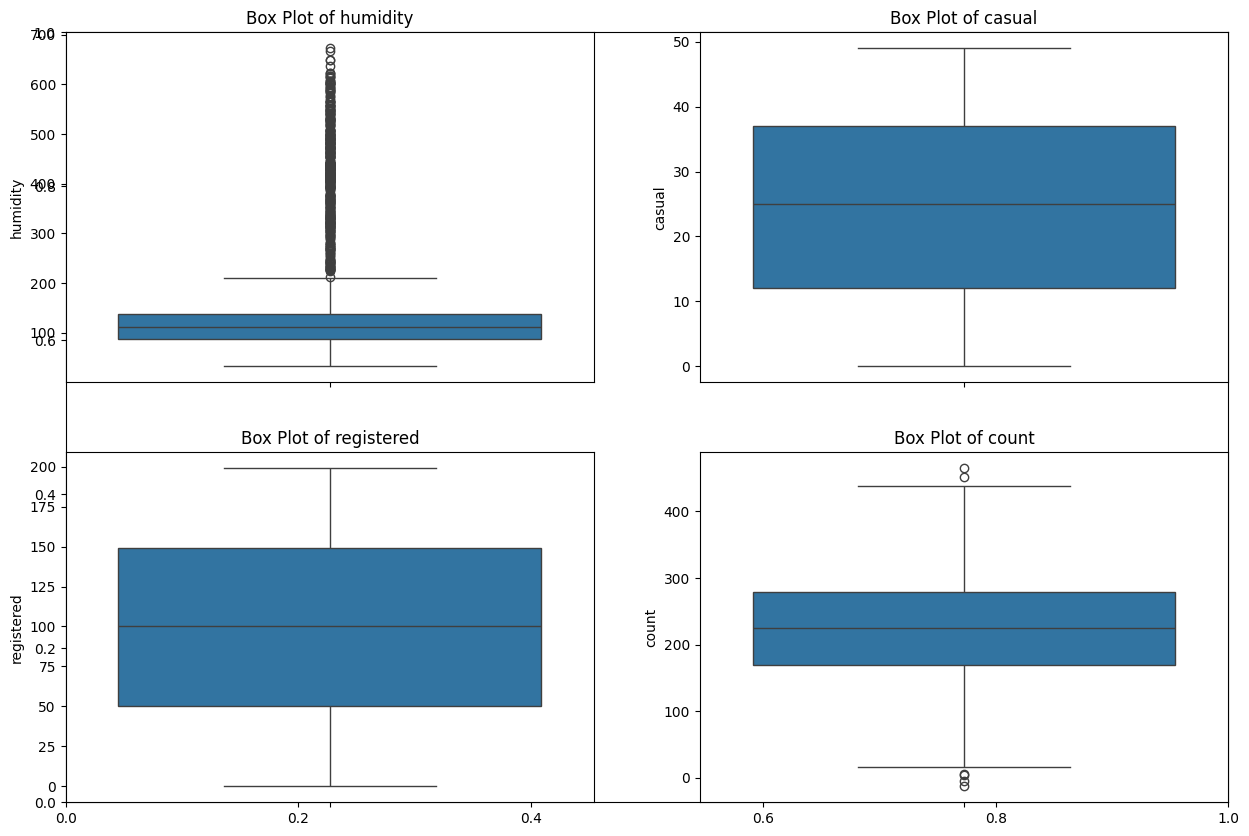

In [25]:
features = ['humidity', 'casual', 'registered', 'count']

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sb.boxplot(df[col])
    plt.title(f'Box Plot of {col}')
plt.show()

check whether there are any highly correlated features in our dataset or not.

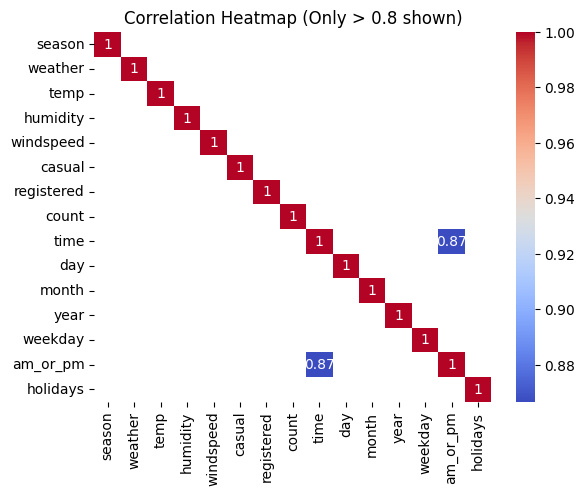

In [26]:
corr = df.corr()
mask = corr.abs() > 0.8

sb.heatmap(corr, annot=True, mask=~mask, cmap='coolwarm')
plt.title("Correlation Heatmap (Only > 0.8 shown)")
plt.show()


In [27]:
df.drop(['registered', 'time'], axis=1, inplace=True)
df = df[(df['windspeed'] < 32) & (df['humidity'] > 0)]

**Model Training**

In [28]:
features = df.drop(['count'], axis = 1)
target = df['count'].values

x_train, x_val , y_train , y_val = train_test_split(features, target , test_size=0.1, random_state=22)
x_train.shape, x_val.shape

((4315, 12), (480, 12))

In [29]:
# Normalize the data before feeding it into the machine learning models

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [30]:
models = [LinearRegression() , Lasso() , RandomForestRegressor(), Ridge()]

for i in range(len(models)):
    models[i].fit(x_train,y_train)

    print(f'{models[i]} :')
    train_preds = models[i].predict(x_train)
    print('Training Error: ', mae(y_train, train_preds))
    val_preds = models[i].predict(x_val)
    print('validation error: ', mae(y_val, val_preds))
    print()

LinearRegression() :
Training Error:  55.51892217832468
validation error:  55.745841896640314

Lasso() :
Training Error:  55.53694549883355
validation error:  55.870723996666

RandomForestRegressor() :
Training Error:  20.61542171362655
validation error:  55.05115172357955

Ridge() :
Training Error:  55.518884098595414
validation error:  55.74662268167663



In [31]:
for model in models:
    scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    print(f"{model.__class__.__name__} | CV MAE: {-scores.mean():.2f}")

LinearRegression | CV MAE: 55.66
Lasso | CV MAE: 55.62
RandomForestRegressor | CV MAE: 55.30
Ridge | CV MAE: 55.66


In [32]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None]
}
grid = GridSearchCV(RandomForestRegressor(), params, cv=3, scoring='neg_mean_absolute_error')
grid.fit(x_train, y_train)
print("Best RF Params:", grid.best_params_)


Best RF Params: {'max_depth': 5, 'n_estimators': 200}


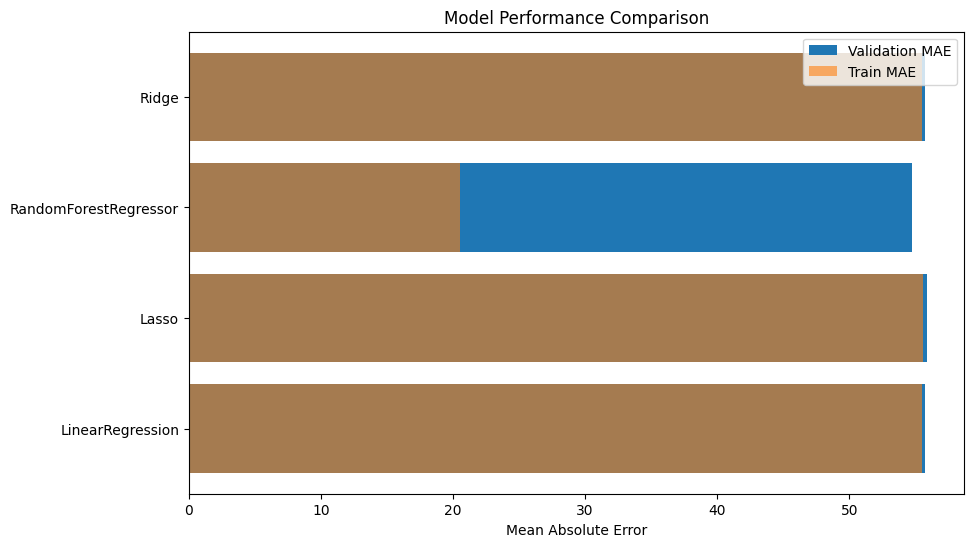

In [33]:
model_names = []
train_errors = []
val_errors = []

for model in models:
    model.fit(x_train, y_train)
    train_mae = mae(y_train, model.predict(x_train))
    val_mae = mae(y_val, model.predict(x_val))

    model_names.append(model.__class__.__name__)
    train_errors.append(train_mae)
    val_errors.append(val_mae)

plt.figure(figsize=(10, 6))
plt.barh(model_names, val_errors, label="Validation MAE")
plt.barh(model_names, train_errors, alpha=0.6, label="Train MAE")
plt.xlabel("Mean Absolute Error")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()


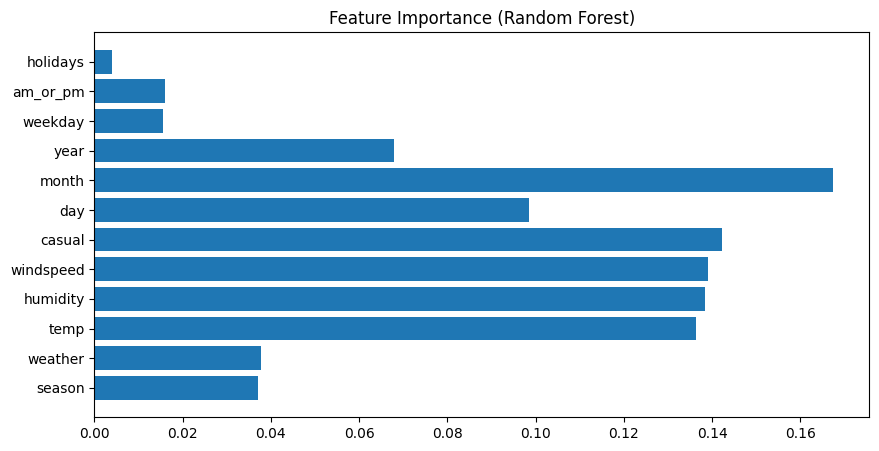

In [34]:
importances = models[2].feature_importances_  # RandomForest assumed
plt.figure(figsize=(10,5))
plt.barh(features.columns, importances)
plt.title("Feature Importance (Random Forest)")
plt.show()
